In [46]:
# imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
# google trends
def merge_and_normalize_trends(dfs, col_name):
    # Start with the first DataFrame
    result = dfs[0].copy()
    for next_df in dfs[1:]:
        # Find overlap
        overlap = set(result["Woche"]) & set(next_df["Woche"])
        if overlap:
            # Use the mean ratio in the overlap to normalize
            overlap = list(overlap)
            result_overlap = result[result["Woche"].isin(overlap)].set_index("Woche")
            next_overlap = next_df[next_df["Woche"].isin(overlap)].set_index("Woche")
            ratio = result_overlap[col_name].mean() / next_overlap[col_name].mean()
        else:
            ratio = 1.0
        # Normalize next_df
        next_df_norm = next_df.copy()
        next_df_norm[col_name] = next_df_norm[col_name] * ratio
        # Append only non-overlapping part
        non_overlap = ~next_df_norm["Woche"].isin(result["Woche"])
        result = pd.concat([result, next_df_norm[non_overlap]], ignore_index=True)
    # Sort by date
    result = result.sort_values("Woche").reset_index(drop=True)
    return result


# Keyword: "Auto Finanzierung"
gt_auto_finanzierung_1 = pd.read_csv("./original_data/gt_auto_finanzierung_1.csv")
gt_auto_finanzierung_2 = pd.read_csv("./original_data/gt_auto_finanzierung_2.csv")
gt_auto_finanzierung_3 = pd.read_csv("./original_data/gt_auto_finanzierung_3.csv")

gt_auto_finanzierung = merge_and_normalize_trends(
    [gt_auto_finanzierung_1, gt_auto_finanzierung_2, gt_auto_finanzierung_3],
    col_name="Auto Finanzierung",
)
gt_auto_finanzierung.rename(columns={"Woche": "DATE"}, inplace=True)
# Keyword: "BMW Finanzierung"
gt_bmw_finanzierung_1 = pd.read_csv("./original_data/gt_bmw_finanzierung_1.csv")
gt_bmw_finanzierung_2 = pd.read_csv("./original_data/gt_bmw_finanzierung_2.csv")
gt_bmw_finanzierung_3 = pd.read_csv("./original_data/gt_bmw_finanzierung_3.csv")

gt_bmw_finanzierung = merge_and_normalize_trends(
    [gt_bmw_finanzierung_1, gt_bmw_finanzierung_2, gt_bmw_finanzierung_3],
    col_name="BMW Finanzierung",
)
gt_bmw_finanzierung.rename(columns={"Woche": "DATE"}, inplace=True)
# Keyword: "Auto Leasing"
gt_auto_leasing_1 = pd.read_csv("./original_data/gt_auto_leasing_1.csv")
gt_auto_leasing_2 = pd.read_csv("./original_data/gt_auto_leasing_2.csv")
gt_auto_leasing_3 = pd.read_csv("./original_data/gt_auto_leasing_3.csv")

gt_auto_leasing = merge_and_normalize_trends(
    [gt_auto_leasing_1, gt_auto_leasing_2, gt_auto_leasing_3], col_name="Auto Leasing"
)
gt_auto_leasing.rename(columns={"Woche": "DATE"}, inplace=True)
# Keyword: "BMW Leasing"
gt_bmw_leasing_1 = pd.read_csv("./original_data/gt_bmw_leasing_1.csv")
gt_bmw_leasing_2 = pd.read_csv("./original_data/gt_bmw_leasing_2.csv")
gt_bmw_leasing_3 = pd.read_csv("./original_data/gt_bmw_leasing_3.csv")
gt_bmw_leasing = merge_and_normalize_trends(
    [gt_bmw_leasing_1, gt_bmw_leasing_2, gt_bmw_leasing_3], col_name="BMW Leasing"
)
gt_bmw_leasing.rename(columns={"Woche": "DATE"}, inplace=True)
# Keyword: "Leasing"
gt_leasing_1 = pd.read_csv("./original_data/gt_leasing_1.csv")
gt_leasing_2 = pd.read_csv("./original_data/gt_leasing_2.csv")
gt_leasing_3 = pd.read_csv("./original_data/gt_leasing_3.csv")
gt_leasing = merge_and_normalize_trends(
    [gt_leasing_1, gt_leasing_2, gt_leasing_3], col_name="leasing"
)
gt_leasing.rename(columns={"Woche": "DATE"}, inplace=True)
# Keyword: "BMW"
gt_bmw_1 = pd.read_csv("./original_data/gt_bmw_1.csv")
gt_bmw_2 = pd.read_csv("./original_data/gt_bmw_2.csv")
gt_bmw_3 = pd.read_csv("./original_data/gt_bmw_3.csv")
gt_bmw = merge_and_normalize_trends([gt_bmw_1, gt_bmw_2, gt_bmw_3], col_name="BMW")
gt_bmw.rename(columns={"Woche": "DATE"}, inplace=True)

gt_bmw

,DATE,BMW
0,2014-12-28,70.000000
1,2015-01-04,69.000000
2,2015-01-11,79.000000
3,2015-01-18,81.000000
4,2015-01-25,76.000000
...,...,...
538,2025-04-20,87.284542
539,2025-04-27,80.010830
540,2025-05-04,80.010830
541,2025-05-11,86.245440


In [48]:
# apgi
apgi = pd.read_csv("./original_data/apgi.csv")

apgi["DATE"] = pd.to_datetime(apgi["DATE"], format="%Y-%m") + pd.offsets.MonthEnd(0)
apgi["DATE"] = apgi["DATE"].dt.strftime("%Y-%m-%d")
apgi

,DATE,AGPI
0,2019-01-31,20462
1,2019-02-28,20666
2,2019-03-31,20648
3,2019-04-30,20620
4,2019-05-31,20371
...,...,...
65,2024-06-30,26656
66,2024-07-31,26626
67,2024-08-31,26792
68,2024-09-30,26480


In [49]:
# arbeitslosenzahlen

month_map = {
    "Januar": "01",
    "Februar": "02",
    "März": "03",
    "April": "04",
    "Mai": "05",
    "Juni": "06",
    "Juli": "07",
    "August": "08",
    "September": "09",
    "Oktober": "10",
    "November": "11",
    "Dezember": "12",
}
arbeitslosenquote = pd.read_csv(
    "./original_data/arbeitslosenzahlen.csv", sep=";", decimal=","
)

# Clean integer columns (remove dots, convert to int)
for col in ["Bestand Arbeitslose", "Zugang Arbeitslose", "Abgang Arbeitslose"]:
    arbeitslosenquote[col] = (
        arbeitslosenquote[col]
        .astype(str)
        .str.replace(".", "", regex=False)
        .replace("", "0")
        .astype(int)
    )

# Clean float column (replace comma with dot, convert to float)
arbeitslosenquote["Arbeitslosenquote"] = (
    arbeitslosenquote["Arbeitslosenquote"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .replace("", "0")
    .astype(float)
)

# Convert 'Berichtsmonat' to datetime
arbeitslosenquote["DATE"] = (
    arbeitslosenquote["Berichtsmonat"]
    .astype(str)
    .apply(
        lambda x: pd.to_datetime(
            f"{x.split(' ')[1]}-{month_map.get(x.split(' ')[0], '01')}-01",
            errors="coerce",
        )
    )
)
arbeitslosenquote["DATE"] = arbeitslosenquote["DATE"] + pd.offsets.MonthEnd(0)

# Reorder columns
arbeitslosenquote = arbeitslosenquote.drop(columns=["Berichtsmonat"])
arbeitslosenquote = arbeitslosenquote[
    ["DATE"] + [col for col in arbeitslosenquote.columns if col != "DATE"]
]

arbeitslosenquote

,DATE,Bestand Arbeitslose,Zugang Arbeitslose,Abgang Arbeitslose,Arbeitslosenquote
0,2025-04-30,2931550,562010,597530,6.3
1,2025-03-31,2967080,577380,599530,6.4
2,2025-02-28,2989220,585600,589050,6.4
3,2025-01-31,2992660,625980,439960,6.4
4,2024-12-31,2806630,562260,529670,6.0
...,...,...,...,...,...
211,2007-09-30,3530640,673130,834200,8.4
212,2007-08-31,3691890,671520,680410,8.8
213,2007-07-31,3701000,775270,746800,8.8
214,2007-06-30,3672930,578000,700850,8.8


In [50]:
# euribor
# 3 months
euribor_3m = pd.read_csv("./original_data/euribor_3m.csv")
euribor_3m = euribor_3m.drop(columns=["TIME PERIOD"])
euribor_3m = euribor_3m.rename(
    columns={
        "Euribor 3-month - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR3MD_.HSTA)": "Euribor 3M"
    }
)
# 6 months
euribor_6m = pd.read_csv("./original_data/euribor_6m.csv")
euribor_6m = euribor_6m.drop(columns=["TIME PERIOD"])
euribor_6m = euribor_6m.rename(
    columns={
        "Euribor 6-month - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR6MD_.HSTA)": "Euribor 6M"
    }
)
# 12 months
euribor_12m = pd.read_csv("./original_data/euribor_12m.csv")
euribor_12m = euribor_12m.drop(columns=["TIME PERIOD"])
euribor_12m = euribor_12m.rename(
    columns={
        "Euribor 1-year - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR1YD_.HSTA)": "Euribor 12M"
    }
)
euribor_12m

,DATE,Euribor 12M
0,1994-01-31,6.3400
1,1994-02-28,6.4200
2,1994-03-31,6.5500
3,1994-04-30,6.4600
4,1994-05-31,6.2500
...,...,...
371,2024-12-31,2.4383
372,2025-01-31,2.5221
373,2025-02-28,2.4069
374,2025-03-31,2.3984


In [51]:
# gebrauchtwagenpreiseindex

gebrauchtwagenpreisindex = pd.read_csv("./original_data/gebrauchtwagenpreisindex.csv")
gebrauchtwagenpreisindex["DATE"] = pd.to_datetime(
    gebrauchtwagenpreisindex["DATE"], errors="coerce"
) + pd.offsets.MonthEnd(0)
gebrauchtwagenpreisindex["DATE"] = gebrauchtwagenpreisindex["DATE"].dt.strftime(
    "%Y-%m-%d"
)

gebrauchtwagenpreisindex

,DATE,Gebrauchtwagenpreisindex
0,2015-01-31,100.0
1,2015-02-28,108.4
2,2015-03-31,111.4
3,2015-04-30,112.2
4,2015-05-31,109.7
...,...,...
119,2024-12-31,137.3
120,2025-01-31,135.2
121,2025-02-28,137.0
122,2025-03-31,138.8


In [52]:
# ifo beschäftigungsbarometer
beschaeftigungsbarometer = pd.read_csv(
    "./original_data/ifo_beschaeftigungsbarometer.csv"
)
beschaeftigungsbarometer["DATE"] = pd.to_datetime(
    beschaeftigungsbarometer["DATE"], errors="coerce"
) + pd.offsets.MonthEnd(0)
beschaeftigungsbarometer["DATE"] = beschaeftigungsbarometer["DATE"].dt.strftime(
    "%Y-%m-%d"
)

beschaeftigungsbarometer

,DATE,Beschäftigungsbarometer,Verarbeitendes Gewerbe,Bauhauptgewerbe,Handel,Dienstleistungssektor
0,2002-01-31,91.9,-23.7,-45.4,-21.6,2.0
1,2002-02-28,92.1,-21.5,-37.2,-22.9,1.5
2,2002-03-31,92.5,-22.1,-34.4,-19.9,1.9
3,2002-04-30,92.0,-19.4,-38.3,-22.9,0.1
4,2002-05-31,92.1,-20.2,-36.8,-22.6,0.8
...,...,...,...,...,...,...
275,2024-12-31,92.5,-22.4,-2.0,-16.7,-2.4
276,2025-01-31,93.4,-22.3,-3.7,-15.6,1.0
277,2025-02-28,93.0,-19.6,-4.5,-15.9,-1.4
278,2025-03-31,92.8,-20.8,-1.8,-12.9,-2.8


In [53]:
# ifo geschäftsklima
geschaeftsklima = pd.read_csv("./original_data/ifo_geschaeftsklima.csv")
geschaeftsklima["DATE"] = pd.to_datetime(
    geschaeftsklima["DATE"].str.strip(), format="%m/%Y"
) + pd.offsets.MonthEnd(0)
geschaeftsklima["DATE"] = geschaeftsklima["DATE"].dt.strftime("%Y-%m-%d")

geschaeftsklima

,DATE,Geschäftsklima,Geschäftslage,Geschäftserwartungen,Konjunkturampel
0,2005-01-31,92.2,87.4,97.2,83.1
1,2005-02-28,92.0,88.0,96.2,50.4
2,2005-03-31,90.1,85.9,94.5,4.9
3,2005-04-30,89.9,86.3,93.7,18.7
4,2005-05-31,89.3,86.1,92.7,11.7
...,...,...,...,...,...
239,2024-12-31,84.7,85.0,84.4,13.0
240,2025-01-31,85.2,86.0,84.3,26.9
241,2025-02-28,85.3,85.0,85.6,30.2
242,2025-03-31,86.7,85.7,87.7,69.9


In [54]:
# bmw sales
bmw_sales = pd.read_csv("./original_data/bmw_sales.csv", sep=";", decimal=",")

bmw_sales

,DATE,SALES
0,2014-12-28,1311
1,2015-01-04,5555
2,2015-01-11,5040
3,2015-01-18,3365
4,2015-01-25,4050
...,...,...
537,2025-04-13,3336
538,2025-04-20,3042
539,2025-04-27,3046
540,2025-05-04,3784


In [55]:
# verbraucherpreisindex
verbraucherpreisindex = pd.read_csv(
    "./original_data/verbraucherpreisindex.csv", sep=";", decimal=","
)

# Columns to clean: replace comma with period and convert to float
cols_to_clean_comma = [
    "Index der Erzeugerpreise gewerblicher Produkte",
    "Index der Einfuhrpreise",
    "Index der Ausfuhrpreise",
]

for col in cols_to_clean_comma:
    verbraucherpreisindex[col] = (
        verbraucherpreisindex[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .replace(
            ".", "0", regex=False
        )  # Handle cases where only a period might be left or as a placeholder
        .replace("", "0")  # Replace empty strings with 0
        .astype(float)
    )

# Convert "Datum" to datetime, then set to last day of month
verbraucherpreisindex["DATE"] = pd.to_datetime(
    verbraucherpreisindex["Datum"], format="%d/%m/%Y"
) + pd.offsets.MonthEnd(0)
verbraucherpreisindex["DATE"] = verbraucherpreisindex["DATE"].dt.strftime("%Y-%m-%d")
verbraucherpreisindex = verbraucherpreisindex.drop(columns=["Datum"])
cols = ["DATE"] + [col for col in verbraucherpreisindex.columns if col != "DATE"]
verbraucherpreisindex = verbraucherpreisindex[cols]

verbraucherpreisindex

,DATE,Verbraucherpreisindex,Index der Einzelhandelspreise,Index der Erzeugerpreise gewerblicher Produkte,Index der Growsshandelsverkaufspreise,Index der Einfuhrpreise,Index der Ausfuhrpreise
0,2012-03-31,91.7,94.2,90.6,93.3,100.7,93.4
1,2012-04-30,91.6,94.3,90.8,93.7,100.4,93.7
2,2012-05-31,91.5,94.1,90.5,93.2,100.0,93.6
3,2012-06-30,91.4,93.9,90.1,92.3,98.6,93.4
4,2012-07-31,91.7,93.5,90.1,92.4,99.0,93.6
...,...,...,...,...,...,...,...
153,2024-12-31,120.5,123.3,128.3,116.3,113.9,115.5
154,2025-01-31,120.3,122.8,128.2,117.4,115.2,116.3
155,2025-02-28,120.8,123.1,128.0,118.1,115.5,116.7
156,2025-03-31,121.2,123.7,127.1,117.9,114.3,116.2


In [56]:
# Merge all dataframes on DATE
from functools import reduce

dataframes = [
    bmw_sales,
    gt_auto_finanzierung,
    gt_bmw_finanzierung,
    gt_auto_leasing,
    gt_bmw_leasing,
    gt_leasing,
    gt_bmw,
    apgi,
    gebrauchtwagenpreisindex,
    euribor_3m,
    euribor_6m,
    euribor_12m,
    verbraucherpreisindex,
    arbeitslosenquote,
    beschaeftigungsbarometer,
    geschaeftsklima,
]

# Ensure all DATE columns are in datetime format
for df_item in dataframes:
    if "DATE" in df_item.columns:
        df_item["DATE"] = pd.to_datetime(df_item["DATE"])

merged = reduce(
    lambda left, right: pd.merge(left, right, on="DATE", how="outer"), dataframes
)
merged.columns = merged.columns.str.replace(r"\s+", "", regex=True)
merged.to_csv("data.csv", index=False)

In [57]:
merged.describe()

,DATE,SALES,AutoFinanzierung,BMWFinanzierung,AutoLeasing,BMWLeasing,leasing,BMW,AGPI,Gebrauchtwagenpreisindex,...,Arbeitslosenquote,Beschäftigungsbarometer,VerarbeitendesGewerbe,Bauhauptgewerbe,Handel,Dienstleistungssektor,Geschäftsklima,Geschäftslage,Geschäftserwartungen,Konjunkturampel
count,902,542.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,70.000000,124.000000,...,216.000000,280.000000,280.000000,280.000000,280.000000,280.000000,244.000000,244.000000,244.000000,244.000000
mean,2015-10-25 04:40:58.536585216,4222.564576,76.985617,52.134767,103.553766,80.469329,88.434926,76.980930,24374.800000,126.795161,...,6.429630,97.577857,-5.296786,-6.657143,-4.851071,6.669286,95.685246,95.872541,95.607787,57.623361
min,1994-01-31 00:00:00,1238.000000,36.000000,0.000000,43.000000,45.517979,41.000000,52.564659,19777.000000,100.000000,...,4.800000,86.800000,-40.000000,-46.200000,-34.700000,-18.300000,75.000000,77.500000,71.000000,0.000000
25%,2012-11-07 12:00:00,3589.500000,68.000000,41.000000,75.000000,70.000000,69.000000,68.738401,20838.750000,110.075000,...,5.700000,93.575000,-15.325000,-11.025000,-11.800000,0.600000,91.175000,90.850000,92.500000,22.300000
50%,2018-03-02 00:00:00,4139.000000,76.000000,51.299692,101.510713,79.191939,90.145670,75.000000,25095.500000,118.550000,...,6.300000,98.600000,-3.700000,-2.750000,-1.950000,8.200000,97.900000,97.900000,97.850000,70.800000
75%,2021-10-08 06:00:00,4799.500000,85.000000,61.840725,129.162821,89.735445,106.209495,80.868707,27243.250000,139.625000,...,7.100000,100.600000,3.450000,2.400000,2.700000,12.300000,100.125000,100.500000,100.525000,92.350000
max,2025-05-18 00:00:00,7485.000000,116.572754,100.000000,331.103049,130.051370,166.936427,404.343534,29333.000000,171.600000,...,9.100000,105.000000,20.400000,18.400000,10.100000,22.600000,105.000000,108.500000,106.100000,100.000000
std,NaN,888.985383,14.021878,14.804852,35.988526,13.414069,22.589151,25.117551,3325.147461,18.987954,...,1.041623,4.394736,12.519835,15.155326,9.939559,7.778201,6.108702,7.074345,6.624954,35.883843


In [58]:
# Data transformation
# Adding Weeks
# Add missing weekly dates if not present
all_weeks = pd.date_range(
    start=merged["DATE"].min(), end=merged["DATE"].max(), freq="W-SUN"
)
missing_weeks = all_weeks.difference(merged["DATE"])
if not missing_weeks.empty:
    missing_df = pd.DataFrame({"DATE": missing_weeks})
    merged = pd.concat([merged, missing_df], ignore_index=True)
    merged = merged.sort_values("DATE").reset_index(drop=True)

    # Keep only rows where DATE is in all_weeks (i.e., weekly dates)
merged = merged[merged["DATE"].isin(all_weeks)].reset_index(drop=True)

# Remove all data before 2015
merged = merged[merged["DATE"] >= pd.Timestamp("2014-01-01")].reset_index(drop=True)

In [59]:
# Interpolating missing values
interpolated = (
    merged.set_index("DATE")
    .interpolate(method="time", limit_direction="both")
    .reset_index()
)

interpolated = interpolated[
    interpolated["DATE"] >= pd.Timestamp("2015-01-01")
].reset_index(drop=True)

In [60]:
# seasonal adjustment
from statsmodels.tsa.seasonal import STL

# List of columns to be seasonally adjusted
seasonal_cols = [
    "SALES",
    "AutoFinanzierung",
    "BMWFinanzierung",
    "AutoLeasing",
    "BMWLeasing",
    "leasing",
    "BMW",
    "AGPI",
    "Gebrauchtwagenpreisindex",
    "Euribor3M",
    "Euribor6M",
    "Euribor12M",
    "BestandArbeitslose",
    "ZugangArbeitslose",
    "AbgangArbeitslose",
    "Arbeitslosenquote",
    "Beschäftigungsbarometer",
    "VerarbeitendesGewerbe",
    "Bauhauptgewerbe",
    "Handel",
    "Dienstleistungssektor",
    "Geschäftsklima",
    "Geschäftslage",
    "Geschäftserwartungen",
    "Konjunkturampel",
]

df_sa = interpolated.copy()
df_sa = df_sa.set_index("DATE")

for col in seasonal_cols:
    if col in df_sa.columns:
        series = df_sa[col].dropna()  # Remove NaNs
        if len(series) > 2 * 52:  # Check if enough data points (period=12)
            stl = STL(series, period=52, robust=True)
            res = stl.fit()
            # Place the seasonally adjusted data back, aligning with the original index
            df_sa[col] = pd.Series(res.trend + res.resid, index=series.index)
        else:
            print(
                f"Column '{col}' has insufficient data points ({len(series)}) for STL decomposition after dropping NaNs. Skipping."
            )
            # Optionally, fill with NaNs or keep original if not enough data
            df_sa[col] = np.nan
    else:
        print(f"Warning: Column '{col}' not found in DataFrame df_sa.")

df_sa = df_sa.reset_index()

In [61]:
# feature engineering
df_fe = df_sa.copy()
df_fe["DATE"] = pd.to_datetime(df_fe["DATE"])

# Create lagged features for SALES at every 4 weeks up to 52 weeks
for lag in range(4, 53, 4):
    df_fe[f"SALES_t{lag}"] = df_fe["SALES"].shift(lag)

# Move the lagged SALES columns to be right after the SALES column
lagged_cols = [f"SALES_t{lag}" for lag in range(4, 53, 4)]
cols = (
    ["DATE", "SALES"]
    + lagged_cols
    + [col for col in df_fe.columns if col not in (["DATE", "SALES"] + lagged_cols)]
)
df_fe = df_fe[cols]

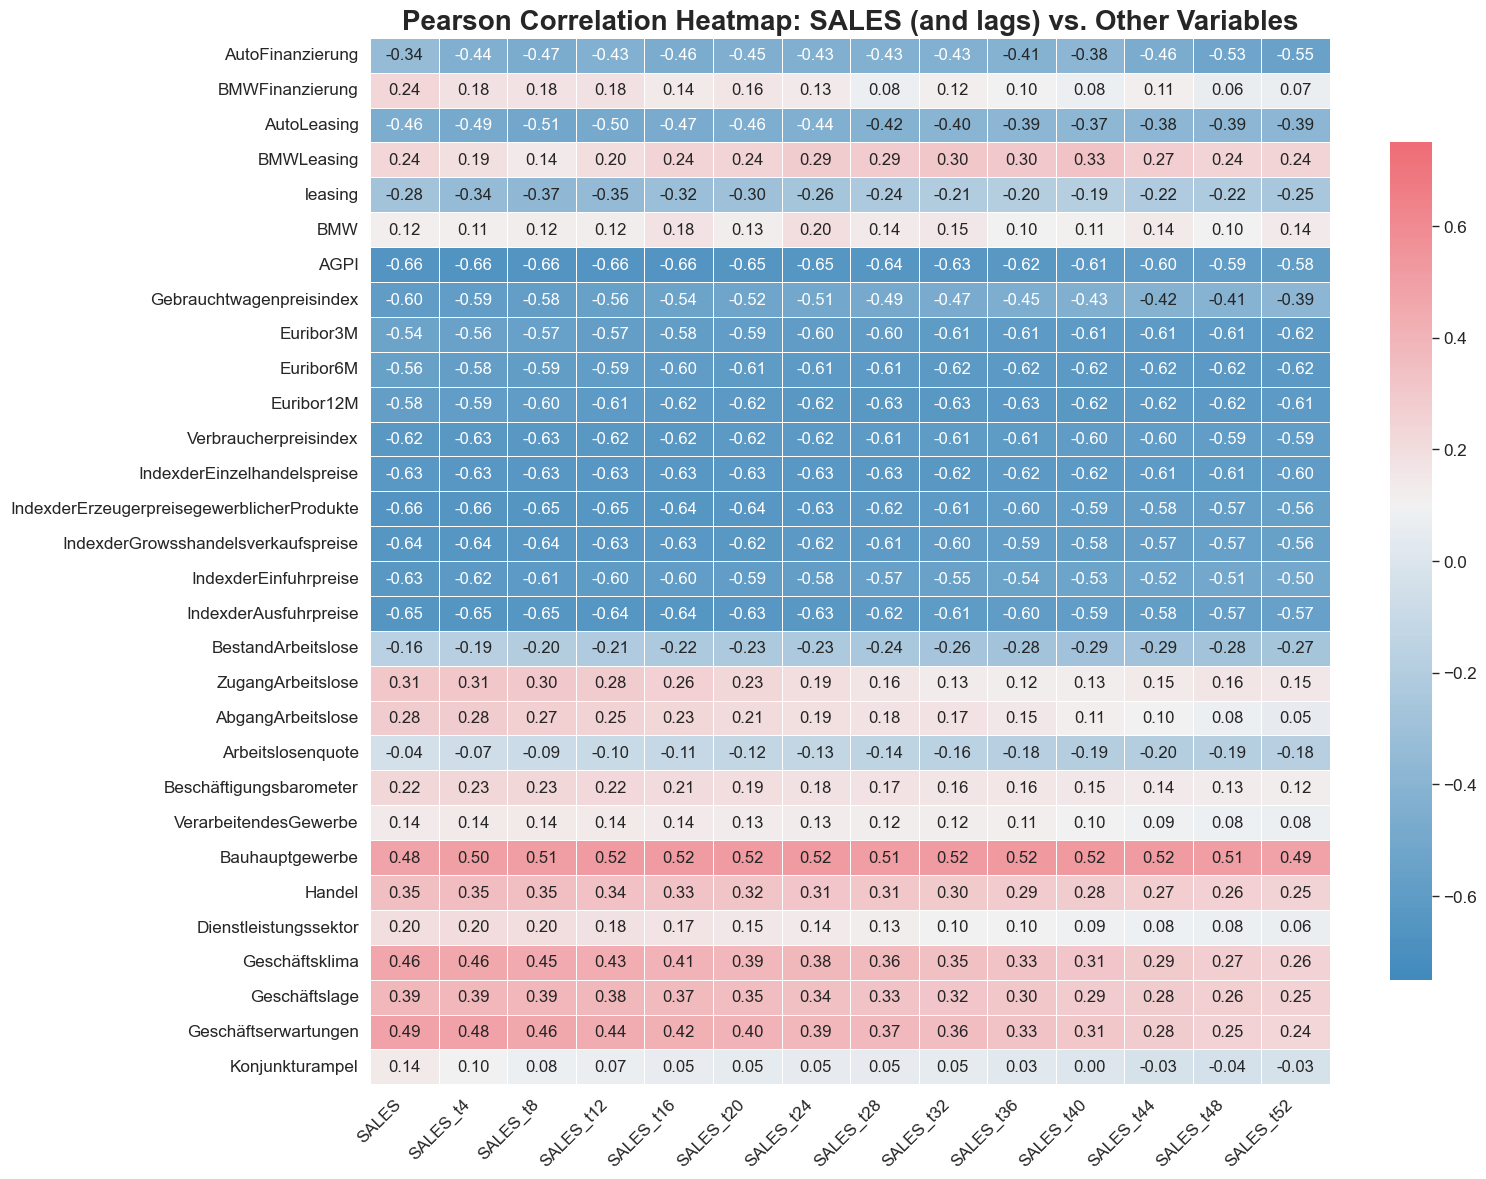


Pearson Correlation Subset:


,SALES,SALES_t4,SALES_t8,SALES_t12,SALES_t16,SALES_t20,SALES_t24,SALES_t28,SALES_t32,SALES_t36,SALES_t40,SALES_t44,SALES_t48,SALES_t52
AutoFinanzierung,-0.344183,-0.441930,-0.466999,-0.429021,-0.464061,-0.446639,-0.433671,-0.430914,-0.431537,-0.414437,-0.384398,-0.463792,-0.525366,-0.553965
BMWFinanzierung,0.239515,0.182569,0.180868,0.182872,0.143752,0.162961,0.134928,0.081801,0.115043,0.096161,0.081985,0.113746,0.061645,0.069240
AutoLeasing,-0.457306,-0.490933,-0.513419,-0.497369,-0.471354,-0.455849,-0.439807,-0.421725,-0.398777,-0.385896,-0.373642,-0.380604,-0.392389,-0.387562
BMWLeasing,0.238141,0.188081,0.135907,0.196992,0.241947,0.243947,0.286006,0.288128,0.304947,0.298924,0.326574,0.271018,0.242026,0.240502
leasing,-0.281079,-0.340419,-0.366416,-0.348779,-0.316322,-0.301918,-0.264884,-0.238942,-0.205991,-0.195354,-0.189197,-0.215540,-0.220591,-0.248493
BMW,0.115754,0.112499,0.119974,0.119279,0.175245,0.125455,0.195722,0.139827,0.148739,0.104489,0.111106,0.142039,0.097062,0.138703
AGPI,-0.660911,-0.662623,-0.661094,-0.660687,-0.658374,-0.654388,-0.649631,-0.642435,-0.633328,-0.624306,-0.612142,-0.601239,-0.590250,-0.581318
Gebrauchtwagenpreisindex,-0.602334,-0.589850,-0.576097,-0.562427,-0.544095,-0.523899,-0.506999,-0.489568,-0.471308,-0.453974,-0.434964,-0.418161,-0.405072,-0.390937
Euribor3M,-0.539718,-0.555228,-0.566457,-0.574565,-0.584993,-0.592349,-0.598058,-0.603146,-0.606790,-0.613107,-0.614835,-0.613727,-0.614753,-0.616973
Euribor6M,-0.560149,-0.575856,-0.585808,-0.594479,-0.602413,-0.608882,-0.610443,-0.614635,-0.615336,-0.620143,-0.618222,-0.616727,-0.616628,-0.618140


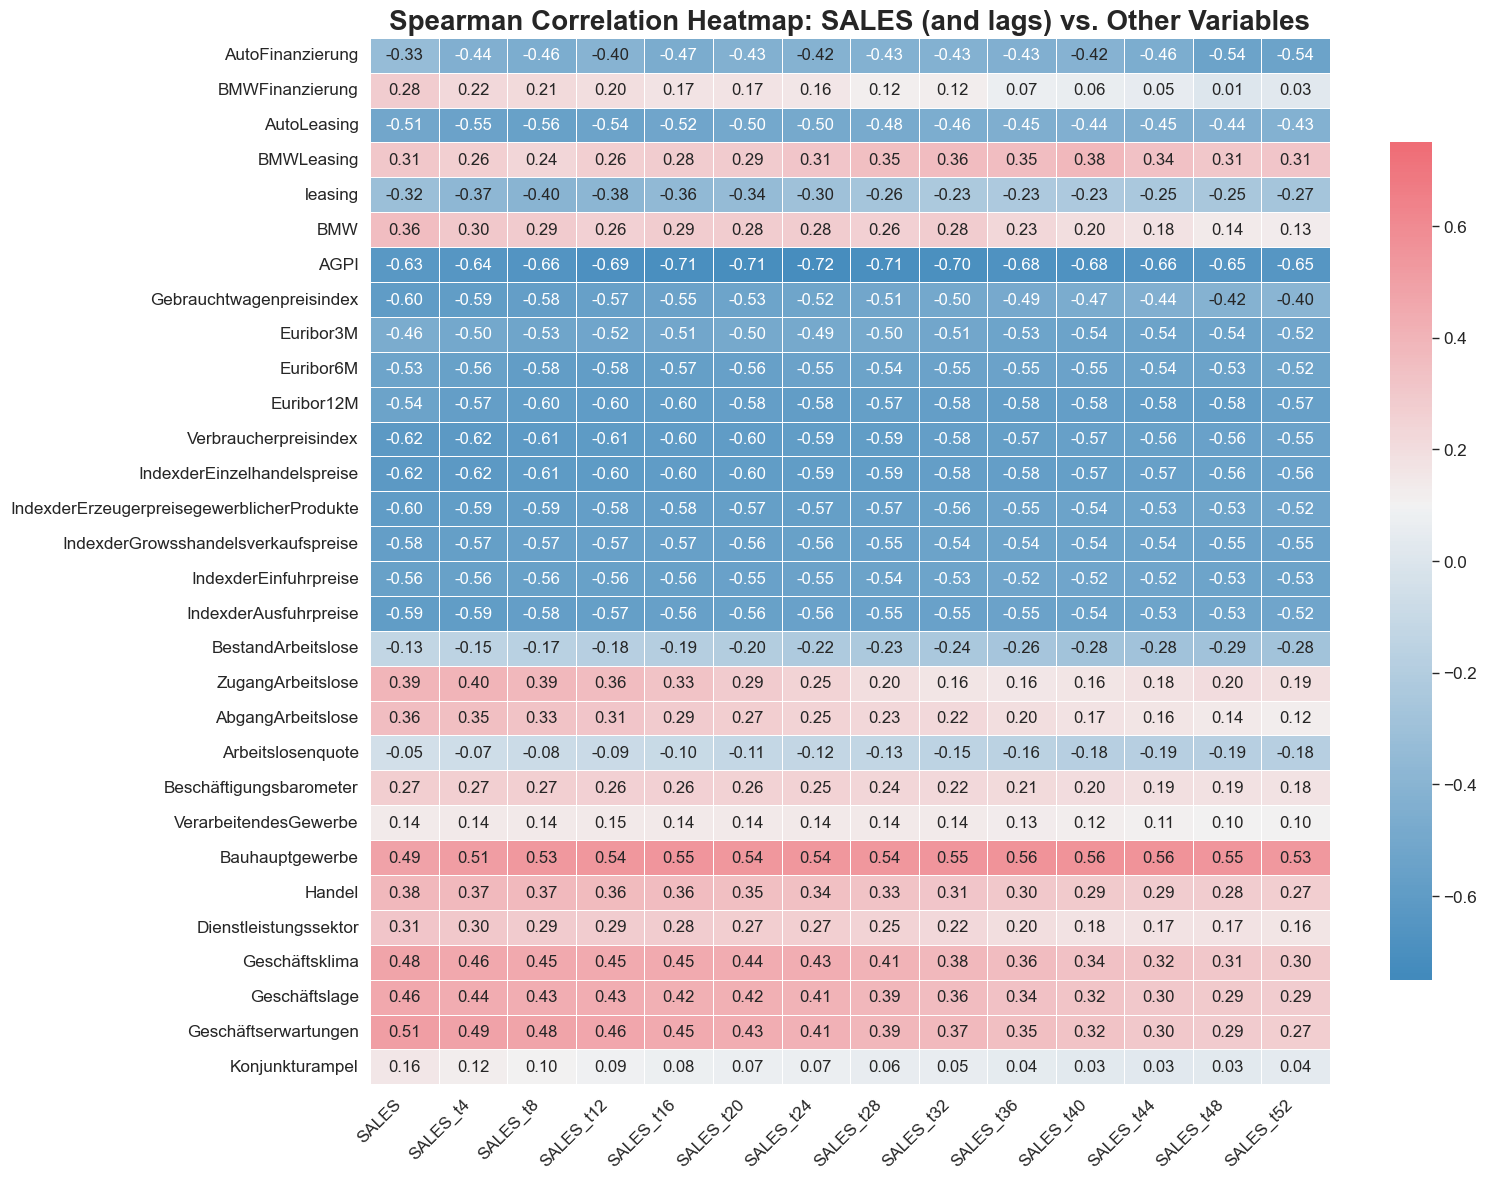


Spearman Correlation Subset:


,SALES,SALES_t4,SALES_t8,SALES_t12,SALES_t16,SALES_t20,SALES_t24,SALES_t28,SALES_t32,SALES_t36,SALES_t40,SALES_t44,SALES_t48,SALES_t52
AutoFinanzierung,-0.331171,-0.438575,-0.457506,-0.404952,-0.465385,-0.428660,-0.420071,-0.425195,-0.426976,-0.434083,-0.415908,-0.462525,-0.536730,-0.541461
BMWFinanzierung,0.278079,0.221051,0.214027,0.198569,0.165704,0.165076,0.157051,0.115924,0.122623,0.066194,0.059651,0.050056,0.005036,0.029219
AutoLeasing,-0.510287,-0.546391,-0.558974,-0.539207,-0.519630,-0.503173,-0.495749,-0.480410,-0.458130,-0.449869,-0.435784,-0.445565,-0.442173,-0.427407
BMWLeasing,0.308279,0.264683,0.237250,0.264742,0.281663,0.289864,0.314104,0.348943,0.362026,0.354049,0.378167,0.336706,0.306709,0.311954
leasing,-0.316214,-0.373648,-0.398534,-0.383586,-0.360525,-0.340044,-0.297128,-0.263739,-0.228764,-0.225931,-0.227789,-0.245469,-0.251178,-0.267471
BMW,0.356641,0.300901,0.288319,0.262839,0.285495,0.280252,0.284626,0.259062,0.276843,0.229996,0.198335,0.180846,0.138572,0.130546
AGPI,-0.632116,-0.640931,-0.657941,-0.686820,-0.708537,-0.709783,-0.719414,-0.708207,-0.696933,-0.675803,-0.676072,-0.660247,-0.645112,-0.650318
Gebrauchtwagenpreisindex,-0.603025,-0.592468,-0.575924,-0.565358,-0.547806,-0.530494,-0.523907,-0.514579,-0.499501,-0.485274,-0.465214,-0.437775,-0.416680,-0.397381
Euribor3M,-0.463504,-0.503635,-0.525233,-0.520436,-0.513432,-0.495810,-0.494769,-0.496539,-0.512005,-0.530353,-0.543656,-0.539414,-0.536044,-0.517171
Euribor6M,-0.530800,-0.562440,-0.583354,-0.583601,-0.572296,-0.564000,-0.545222,-0.543449,-0.547397,-0.546985,-0.548991,-0.542057,-0.534535,-0.523163


In [62]:
# Define target columns (SALES and its lags)
target_cols = ["SALES"] + [f"SALES_t{i}" for i in range(4, 53, 4)]

# Define other columns (all columns except DATE and target_cols)
other_cols = [col for col in df_fe.columns if col not in target_cols + ["DATE"]]

correlation_methods = ["pearson", "spearman"]
for method in correlation_methods:

    # Calculate the correlation matrix between target_cols and other_cols
    correlation_matrix = df_fe[target_cols + other_cols].corr(method=method)

    # Select the relevant part of the correlation matrix
    correlation_subset = correlation_matrix.loc[other_cols, target_cols]

    # Set the style and context for the plot
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.4)

    # Define a custom diverging colormap
    custom_palette = sns.diverging_palette(
        240, 10, s=80, l=55, n=256, center="light", as_cmap=True
    )

    # Plot the heatmap
    plt.figure(figsize=(16, 12))
    sns.heatmap(
        correlation_subset,
        annot=True,
        cmap=custom_palette,
        fmt=".2f",
        vmin=-0.75,
        vmax=0.75,
        center=0.1,  # Set the midpoint to ensure values around 0.20 remain close to white
        annot_kws={"size": 12},  # Adjust annotation text size
        linewidths=0.5,  # Add lines between cells
        cbar_kws={"shrink": 0.8},  # Adjust color bar size
    )

    plt.title(
        f"{method.capitalize()} Correlation Heatmap: SALES (and lags) vs. Other Variables",
        fontsize=20,
        fontweight="bold",
    )

    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
    plt.yticks(rotation=0)  # Keep y-axis labels horizontal
    plt.tight_layout()  # Ensure everything fits in the figure
    plt.show()

    print(f"\n{method.capitalize()} Correlation Subset:")

    display(correlation_subset)